# Sloane Lab XML Parser

This notebook parses the TEI XML files from the Enlightenment Architectures project, extracts the data that we want to import into the Sloane Lab knowledge base, and checks if there are any errors or inconsistencies.

#### Import libraries

In [1]:
# -*- coding: future_fstrings -*-
import os
import re
import sys
import urllib
import titlecase
import pandas as pd

import rdflib
from rdflib import Namespace, URIRef, BNode, Literal
from rdflib.namespace import RDF, RDFS, OWL, XSD

from viapy import api
from bs4 import BeautifulSoup as Soup
from mapboxgl.utils import *
from mapboxgl.viz import *

from matplotlib import *
import matplotlib.pyplot as plt
%matplotlib inline

#### XML File path

In [2]:
# XML file path
XML_PATH = 'data/fossils_v.xml'

#### Function to handle catalogue numbers

In [3]:
# Function to transform the catalogue number to an integer
def cat_to_int(catnum):
    catnum = re.search('\d+', catnum)
    if catnum:
        return int(catnum.group(0))
    return None

#### Load all catalogues and their entries

In [4]:
# Open the XML file
with open(XML_PATH) as xml_file:

    # Read the file
    xml = xml_file.read()
    
    # Parse the file
    parsed_xml = Soup(xml, 'lxml')
    
    # Create empty list of people
    people_list = []
    
    # Create empty list of places
    place_list = []
    
    # For each person in the XML list...
    for person in parsed_xml.find('listperson').find_all('person'):

        # Create dictionary with person's internal ID
        person_dict = {'id': person['xml:id']}
        
        # Find the person's external IDs
        person_ids = person.find_all('idno')
        
        # For each external ID...
        for person_id in person_ids:

            # If the type of ID is VIAF...
            if person_id['type'] == 'viaf':
                
                # Add VIAF ID to person dictionary
                person_dict['viaf'] = person_id.text 
 
            # Otherwise, print person
            else:
                print(person)
 
        person_dict['names'] = [x.text for x in person.find_all('persname')]

        # Add the dictionary to the list
        people_list.append(person_dict)
    
    # For each place in the XML list...
    for place in parsed_xml.find('listplace').find_all('place'):
        
        # Create dictionary with place's internal ID
        place_dict = {'id': place['xml:id']}

        # Find the person's external IDs
        place_ids = place.find_all('idno')
        
        # For each external ID...
        for place_id in place_ids:
            
            # If the type of ID is VIAF...
            if place_id['type'] == 'viaf':
            
                # Add VIAF ID to place dictionary
                place_dict['viaf'] = place_id.text

            # If the type of ID is GEO...
            elif place_id['type'] == 'geo':
                
                try:
                    # Extract latitude and longitude
                    lat, lon = place_id.text.split(',')
                
                    # Add latitude to place dictionary
                    place_dict['lat'] = float(lat.strip())
                
                    # Add longitude to place dictionary
                    place_dict['lon'] = float(lon.strip())
                except:
                    print(place)
                
            # Otherwise, print place
            else:
                print(place)
        
        place_dict['names'] = [x.text for x in place.find_all('placename')]
            
        # Add the dictionary to the list
        place_list.append(place_dict)

# Open the JSON file
#with open("out/people.json", "w") as people_file:
#    json.dump(people_list, people_file)

# Open the JSON file
#with open("out/places.json", "w") as places_file:
#    json.dump(place_list, places_file)

<place xml:id="Eichstadt">
<placename>Eichstadt</placename>
<idno type="viaf">124967002</idno>
<idno type="geo"> 124967002</idno>
</place>
<place xml:id="Hispaniola">
<placename>Hispaniola</placename>
<placename>wreck on the coast of Espanola</placename>
<idno type="viaf">242111207</idno>
<idno type="geo"> failed</idno>
</place>
<place xml:id="Katzenelnbogen">
<placename>Country of Catzellenbogen &amp; belonging to the Landgrave of Hesse cassell,
       northward of Mayence</placename>
<idno type="viaf">129154192 </idno>
<idno type="geo"> 50.26745,†7.97322</idno>
</place>
<place xml:id="Manila">
<placename>Maniglia in the East Indies </placename>
<idno type="viaf">128902416</idno>
<idno type="geo"> 14.6042,†120.9822</idno>
</place>
<place xml:id="Melo_Island">
<placename>Melo Island</placename>
<idno type="geo"> 11.03333,†-15.21667</idno>
</place>
<place xml:id="New_England">
<placename>New England</placename>
<idno type="geo"> 44,†-71</idno>
</place>
<place xml:id="Oundle">
<placename

In [5]:
# List of catalogues
cats = []

# Open the XML file
with open(XML_PATH) as xml_file:

    # Find all catalogues in the manuscript
    catalogues = parsed_xml.find_all('div2')
    
    print(len(catalogues))
    
    prevDict = {}
    
    pageNum = "NHM-UK_L_433034_001a"
    prevPageNum = None
    prevParent = None
    force = False
    
    # For each catalogue...
    for catalogue in catalogues:
        
        # Create catalogue dictionary
        cat_dict = {}
        
        # Create list of entries
        cat_dict['entries'] = []
        
        # Get catalogue title
        cat_dict['title'] = catalogue.find('label').text
        
        # Find all entries in the catalogue
        entries = catalogue.find_all('div3')
    
        # For each entry...
        for entry in entries:
            
            # Get number of entry
            catnum = entry.find('ea:catnum').get_text() if entry.find('ea:catnum') else None
            
            # Get people
            people = entry.find_all('persname')
            
            # Get places
            places = entry.find_all('placename')
            
            # Create entry dictionary
            entry_dict = {
                'num_str': ' '.join(catnum.split()) if catnum else None,
                'num_int': cat_to_int(catnum) if catnum else None,
                'text': ' '.join(entry.text.split()),
                'people': [{'id': x['ref'].strip('#') if 'ref' in x.attrs else None, 'name': ' '.join(x.text.split())} for x in people] if people else None,
                'places': [{'id': x['ref'].strip('#') if 'ref' in x.attrs else None, 'name': ' '.join(x.text.split())} for x in places] if places else None
            }
        
            # Append entry to entry list
            cat_dict['entries'].append(entry_dict)
        
        # Append catalogue to catalogue list
        cats.append(cat_dict)

4


#### How many people in the list?

In [6]:
len(people_list)

2706

#### How many places in the list?

In [7]:
len(place_list)

553

#### How many catalogues?

In [8]:
# Print number of catalogues
len(cats)

4

#### What are their titles?

In [9]:
# Print all catalogue titles
[x['title'].strip() for x in cats]

['Fishes.', 'Birds.', 'Eggs.', 'Quadrupeds.']

#### What are their lengths?

In [10]:
# Compute catalogue lengths
for x in cats:
    x['length'] = len(x['entries'])

[x['length'] for x in cats]

[1606, 964, 257, 1956]

#### Transform the list of catalogues into a dataframe

In [11]:
cat_df = pd.DataFrame(cats)
cat_df

,entries,title,length
0,"[{'num_str': '-1484.', 'num_int': 1484, 'text'...",Fishes.,1606
1,"[{'num_str': None, 'num_int': None, 'text': '1...",Birds.,964
2,"[{'num_str': None, 'num_int': None, 'text': '2...",Eggs.,257
3,"[{'num_str': None, 'num_int': None, 'text': '2...",Quadrupeds.,1956


#### Display the lengths of the catalogues

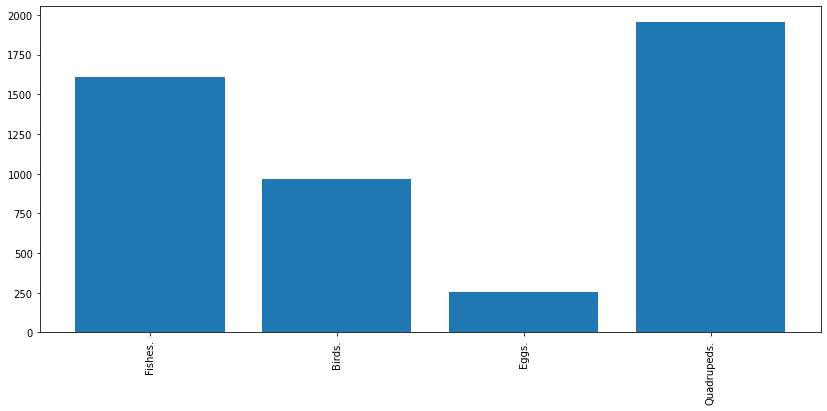

In [12]:
plt.figure(figsize=(14,6))
plt.xticks(range(30), rotation='vertical')
plt.bar(cat_df['title'],cat_df['length'])
plt.show()

#### First catalogue: Coralls

In [13]:
# Check first catalogue
cats[0]

{'entries': [{'num_str': '-1484.',
   'num_int': 1484,
   'text': '-1484. A very large sharks jaw from the coast of Guinea. 241 f <',
   'people': None,
   'places': [{'id': 'Guinea', 'name': 'Guinea'}]},
  {'num_str': '-1485.',
   'num_int': 1485,
   'text': '-1485. A wholes eye from Capt. Craycoot. m. 7',
   'people': [{'id': None, 'name': 'Capt. Craycoot.'}],
   'places': None},
  {'num_str': '-1486.',
   'num_int': 1486,
   'text': '-1486. Bones from the heads of fishes small. P. 221. i.',
   'people': None,
   'places': None},
  {'num_str': '-1487.',
   'num_int': 1487,
   'text': '-1487. 22 W larger. 221. i.',
   'people': None,
   'places': None},
  {'num_str': '-1488.',
   'num_int': 1488,
   'text': '-1488. Dentes raiæ. 221. i.',
   'people': None,
   'places': None},
  {'num_str': '-1489.',
   'num_int': 1489,
   'text': '-1489. Lapides e capite carpionum. L. 221. i.',
   'people': None,
   'places': None},
  {'num_str': '-1490.',
   'num_int': 1490,
   'text': "-1490. Ova pi

#### What is the first catalogue?

In [14]:
# Print title of first catalogue
cats[0]['title']

'Fishes.'

#### How many catalogue entries?

In [15]:
# Print number of entries in first catalogue
len(cats[0]['entries'])

1606

#### What is the first entry?

In [16]:
# Print first entry
cats[0]['entries'][0]

{'num_str': '-1484.',
 'num_int': 1484,
 'text': '-1484. A very large sharks jaw from the coast of Guinea. 241 f <',
 'people': None,
 'places': [{'id': 'Guinea', 'name': 'Guinea'}]}

#### Put all the data in a dataframe

In [17]:
# List of dataframes
dataframes = []

# For each catalogue (excluding indexes)...
for cat in [x for i, x in enumerate(cats) if i not in (3, 6)]:

    # Create dataframe from each catalogue
    df = pd.DataFrame(cat['entries'])

    # Set visualisation options
    pd.options.display.precision = 0

    # Print the dataframe
    df

    # Drop nulls
    df = df.dropna(subset=['num_int'])

    # Sort by entry number
    df = df.sort_values(by=['num_int'])
    
    # Append dataframe to list
    dataframes.append(df)

# Print the first dataframe
dataframes[0]

,num_str,num_int,text,people,places
19,1.,1,3 Fishes. 1. Canis Carchariæ alt. Spec. u. p. ...,None,None
20,2.,2,2. Canis Carchariæ pinna. 241.,None,None
21,3.,3,3. Canis Carchariæ cauda. 4 f < 241.,None,None
22,4.,4,4. Canis Carchariæ mandibulæ. f < 241 &c,None,None
23,5.,5,5. A black slate with the impression of a fish...,None,None
...,...,...,...,...,...
191,1559.,1559,8a 1559. The Head of a large Fish described by...,"[{'id': None, 'name': 'Catesby'}]",None
192,1560.,1560,1560. Sp. Roon A pair of large Fins of some fi...,None,None
193,1561.,1561,1561. Sp. Roon A young Shark stuff'd. D o.,None,None
194,1562,1562,1562 A small orbis. D o. 221. p.,None,None


#### Declare prefixes and create graph

In [18]:
# Create namespaces
slb=Namespace("http://sloanelab.org/");
ecrm=Namespace("http://erlangen-crm.org/current/");
crmdig=Namespace("http://www.ics.forth.gr/isl/CRMdig/");

# Create graph
graph = rdflib.Graph()

# Bind prefixes
graph.bind("slb", slb)
graph.bind("ecrm", ecrm)
graph.bind("crmdig", crmdig)

#### Add catalogues

In [19]:
# Manuscript
msIRI = slb[f'E22/fossils_v'];
graph.add((msIRI, RDF.type, ecrm['E22_Human-Made_Object']))
graph.add((msIRI, ecrm.P2_has_type, slb['E22/manuscript']))
graph.add((msIRI, RDFS.label, Literal('Fossils V')))

# XML
xmlIRI = slb[f'D1/fossils_v'];
graph.add((xmlIRI, RDF.type, crmdig.D1_Digital_Object))
graph.add((xmlIRI, ecrm.P2_has_type, slb['E55/historical_dataset']))
graph.add((xmlIRI, RDFS.label, Literal('Fossils V')))

# Link XML to manuscript
graph.add((xmlIRI, slb['P130.10_contains_elements_of'], msIRI))

# Catalogues
cat1IRI = slb[f'E73/fishes'];
graph.add((cat1IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat1IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat1IRI, RDFS.label, Literal('Fishes')))

cat2IRI = slb[f'E73/birds'];
graph.add((cat2IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat2IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat2IRI, RDFS.label, Literal('Birds')))

cat3IRI = slb[f'E73/eggs'];
graph.add((cat3IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat3IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat3IRI, RDFS.label, Literal('Eggs')))

cat4IRI = slb[f'E73/quadrupeds'];
graph.add((cat4IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat4IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat4IRI, RDFS.label, Literal('Quadrupeds')))

graph.add((xmlIRI, ecrm.P148_has_component, cat1IRI))
graph.add((xmlIRI, ecrm.P148_has_component, cat2IRI))
graph.add((xmlIRI, ecrm.P148_has_component, cat3IRI))
graph.add((xmlIRI, ecrm.P148_has_component, cat4IRI))

<Graph identifier=N0461e413b2a34b459b59d33c533babe9 (<class 'rdflib.graph.Graph'>)>

In [20]:
catNames = ['fishes', 'birds', 'eggs', 'quadrupeds']

# For each dataframe...
for i, df in enumerate(dataframes):

  # For each row in the dataframe...
  for index, row in df.iterrows():
    
    # Get entry number
    entryNumStr = row["num_str"]
    entryNumInt = int(row["num_int"])
    
    # Get entry text
    entryText = row["text"]
    
    # Get people and places
    people = row["people"] or []
    places = row["places"] or []
    
    # Create entry IRI
    entryIRI = slb[f'E73/{catNames[i]}/{entryNumInt}'];
    
    # Create page IRI
    # pageIRI = slb[f'E19/miscellanies/{pageID}'];

    catTitle = titlecase.titlecase(catNames[i].replace('_',' '))
    
    # Add entry to graph
    graph.add((entryIRI, RDF.type, ecrm.E73_Information_Object))
    graph.add((entryIRI, RDFS.label, Literal(f'{catTitle} Entry {entryNumInt}')))
    graph.add((entryIRI, ecrm.P2_has_type, slb['E55/catalogue_entry']))
    
    # Add entry text to graph
    graph.add((entryIRI, ecrm.P190_has_symbolic_content, Literal(entryText)))
    
    # Add entry number to graph
    graph.add((entryIRI, ecrm.P1_is_identified_by, Literal(entryNumStr)))
    
    # Add page to graph
    # graph.add((pageIRI, RDF.type, ecrm.E19_Physical_Object))
   
    # Connect entry to page
    # graph.add((pageIRI, ecrm.P128_carries, entryIRI))
    
    # Connect entry to catalogue
    graph.add((slb[f'E73/{catNames[i]}'], ecrm.P148_has_component, entryIRI))
    
    # Create object IRI
    objIRI = slb[f'E19/{catNames[i]}/{entryNumInt}'];
    
    # Connect entry to object
    graph.add((objIRI, RDF.type, ecrm.E19_Physical_Object))
    graph.add((objIRI, RDFS.label, Literal(f'{catTitle} Object {entryNumInt}')))
    graph.add((entryIRI, ecrm.P129_is_about, objIRI))

    # For each person...
    for person in people:
        
        if not person["id"]:
            print(person)
        else:
            # Create person IRI
            personIRI = slb[f'E21/{person["id"].strip().replace(" ", "_")}'];
        
            # Connect person to entry
            graph.add((entryIRI, ecrm.P67_refers_to, personIRI))

    # For each place...
    for place in places:
        
        # Create place IRI
        try:
            placeIRI = slb[f'E53/{place["id"].strip().replace(" ", "_")}'];
        except AttributeError:
            print(place["id"])
        else:
            graph.add((entryIRI, ecrm.P67_refers_to, placeIRI))

None
{'id': None, 'name': 'M r. Maidstone.'}
None
None
{'id': None, 'name': 'Reaumur'}
{'id': None, 'name': 'D. F.'}
{'id': None, 'name': 'M r. Fortrey'}
{'id': None, 'name': 'Coll. Wharton.'}
{'id': None, 'name': 'Dr. Preston.'}
{'id': None, 'name': 'Dr. Waldo'}
None
{'id': None, 'name': 'Bell'}
None
None
None
None
None
{'id': None, 'name': 'Dr. Leigh'}
{'id': None, 'name': 'M r. Massy'}
None
{'id': None, 'name': 'Dr. Walraven'}
{'id': None, 'name': 'M r. Beverland.'}
{'id': None, 'name': 'M r. Bonivert.'}
None
None
{'id': None, 'name': 'Clark'}
{'id': None, 'name': 'Bell.'}
{'id': None, 'name': 'Dampier'}
None
{'id': None, 'name': 'D. N'}
{'id': None, 'name': 'Lluid.'}
{'id': None, 'name': 'M r. Floyd'}
{'id': None, 'name': 'Dr. Robinson.'}
{'id': None, 'name': 'M r. Floid.'}
{'id': None, 'name': 'M r. Floid.'}
{'id': None, 'name': 'D. Floid.'}
{'id': None, 'name': 'M r. Petiver.'}
{'id': None, 'name': 'D r. Preston.'}
{'id': None, 'name': 'Dr. Stuart.'}
None
None
{'id': None, 'name'

{'id': None, 'name': 'M r. Oglethorp.'}
{'id': None, 'name': 'M r. Fabre.'}
{'id': None, 'name': 'M r. Winthorp.'}
{'id': None, 'name': 'M r. Consett'}
{'id': None, 'name': 'Dr. Mortemar'}
{'id': None, 'name': 'M r. Bell.'}
{'id': None, 'name': 'Cap t. Craford.'}
{'id': None, 'name': 'M r. Craford'}
None
{'id': None, 'name': 'M r. Beerly.'}
{'id': None, 'name': 'M r. Jenkins.'}
{'id': None, 'name': 'M r. Clarke.'}
{'id': None, 'name': 'Cap t. Crayfoot'}
{'id': None, 'name': 'Cap t. Cray'}
None
{'id': None, 'name': 'M r. Adams.'}
{'id': None, 'name': 'M r. Clarke.'}
{'id': None, 'name': 'M r. Laurie.'}
{'id': None, 'name': 'M r. Adams'}
{'id': None, 'name': 'Cap t. Crayfoot.'}
{'id': None, 'name': 'Cap t. Blithouse.'}
None
{'id': None, 'name': 'M r. Catesby.'}
{'id': None, 'name': 'Dr. Hampe.'}
{'id': None, 'name': 'M r. Theobalds.'}
{'id': None, 'name': 'M r. Copping.'}
{'id': None, 'name': 'M r. Swymmer.'}
None
{'id': None, 'name': 'Cap t. Jenkins.'}
None
{'id': None, 'name': 'M r. M'

{'id': None, 'name': 'my daughter Cadogan'}
{'id': None, 'name': 'M r. Dogly'}
{'id': None, 'name': 'M r. W'}
{'id': None, 'name': 'M r. Clerk.'}
{'id': None, 'name': 'Capt. Walker.'}
None
{'id': None, 'name': 'M rs Deering.'}
None
{'id': None, 'name': 'M r. Barrets'}
None
{'id': None, 'name': 'M r. Collier.'}
{'id': None, 'name': 'Capt. Cray coot'}
None
None
{'id': None, 'name': 'Capt. Cray coot'}
{'id': None, 'name': 'my neice Sloane'}
{'id': None, 'name': 'M r. Vernons.'}
{'id': None, 'name': 'Lluid.'}
{'id': None, 'name': 'Lluid.'}
None
{'id': None, 'name': 'Vernon'}


#### Add catalogue entries

In [21]:
name_query = """
PREFIX ecrm: <http://erlangen-crm.org/current/>

SELECT ?person ?label

WHERE {
    ?person rdf:type ecrm:E21_Person .
    ?person rdfs:label ?label .
}
"""

# Return a dataframe containing all names
names = pd.DataFrame(graph.query(name_query), columns=["person", "label"])
names[0:10]

,person,label


In [22]:
print(len(graph))

24574


In [23]:
graph.serialize(destination='/Users/danielemetilli/Downloads/sloane-graph-fossils-v.ttl', format="turtle");